# Reto del Titanic

In [28]:
#============================================================================
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Machine Learning
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                              StackingClassifier)
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             f1_score, precision_score,
                             plot_confusion_matrix,
                             roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore",
                        category=sklearn.exceptions.UndefinedMetricWarning)

# ============================================================================

In [57]:
# ============================================================================
# Lectura de datos
data = pd.read_csv("DATA/train.csv",na_values='.')
test = pd.read_csv("DATA/test.csv", na_values='.')
pid = test.PassengerId

data.describe()
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Se considera que el nombre no aporta ninguna decision sustancial dado que solamente sirve como identificador y esa funcion la cumple prefectamente

La variabe (PassengerID), por tanto se elimina de la base de datos. 

Por otra parte, también la variable (Ticket) tiene valores unicos que no aportan nadal modelo, se elimina también. 

Se eliminan tanto de las dos bases de datos (entrenamiento y testeo) 

In [58]:
# columnas a eliminar: La de nombres (3) y la del Ticket (8): No nos interesan. 
name_data = data.columns[3]
ticket_data = data.columns[8]

name_test = test.columns[2]
ticket_test = test.columns[7]

data = data.drop([name_data, ticket_data], axis=1)
test = test.drop([name_test, ticket_test], axis=1)

data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329
Cabin,204,147,C23 C25 C27,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se puede notar que existen espacios vacios por la fila de Count.  Luego de esto se debe hacer ingenieria de parámetros para poder rellenar los espacios en blanco y asi poder entrenar con seguridad que los modelos. Se reemplaza valores vacios por el promedio de edad del conjunto de datos. 

In [55]:
''' data_prueba=data
test_prueba=test

# print(test.isna().sum())
Age_test = test_prueba.columns[3]
Fare_test = test_prueba.columns[6]
Cabin_test = test_prueba.columns[7]

# print(data.isna().sum())
Age_data = data_prueba.columns[4]
Cabin_data = data_prueba.columns[8]
Embarked_data = data_prueba.columns[9]

# se reemplaza valores vacios por el promedio de edad del conjunto de datos

data_prueba[Age_data].fillna(value=round(data_prueba.Age.mean()), inplace=True)
test_prueba[Age_test].fillna(value=round(test_prueba.Age.mean()), inplace=True)

# Se reemplaza los valores vacios por U, elección arbitraria

test_prueba.Cabin.fillna(value="U", inplace=True)
data_prueba.Cabin.fillna(value="U", inplace=True)

# por utlimo la variable embarked tiene 2 posiciones vacias las reemplazamos
# arbitrariamente con S, aunque puede ser a elección

data_prueba[Embarked_data].fillna(value="S", inplace=True)

# Para test se rellena con el promedio de datos en la variables Fare

test_prueba[Fare_test].fillna(test_prueba.Fare.mean(), inplace=True)

data_prueba.describe(include='all').transpose() '''

' data_prueba=data\ntest_prueba=test\n\n# print(test.isna().sum())\nAge_test = test_prueba.columns[3]\nFare_test = test_prueba.columns[6]\nCabin_test = test_prueba.columns[7]\n\n# print(data.isna().sum())\nAge_data = data_prueba.columns[4]\nCabin_data = data_prueba.columns[8]\nEmbarked_data = data_prueba.columns[9]\n\n# se reemplaza valores vacios por el promedio de edad del conjunto de datos\n\ndata_prueba[Age_data].fillna(value=round(data_prueba.Age.mean()), inplace=True)\ntest_prueba[Age_test].fillna(value=round(test_prueba.Age.mean()), inplace=True)\n\n# Se reemplaza los valores vacios por U, elección arbitraria\n\ntest_prueba.Cabin.fillna(value="U", inplace=True)\ndata_prueba.Cabin.fillna(value="U", inplace=True)\n\n# por utlimo la variable embarked tiene 2 posiciones vacias las reemplazamos\n# arbitrariamente con S, aunque puede ser a elección\n\ndata_prueba[Embarked_data].fillna(value="S", inplace=True)\n\n# Para test se rellena con el promedio de datos en la variables Fare\n\nt

Otra manera de hacerlo es utilizando una paqueteria que completa los valores con valores aleatorios. 


In [56]:
data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329
Cabin,204,147,C23 C25 C27,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
print(data.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64


'/Users/usuariomac/Desktop/ML/missing.png'

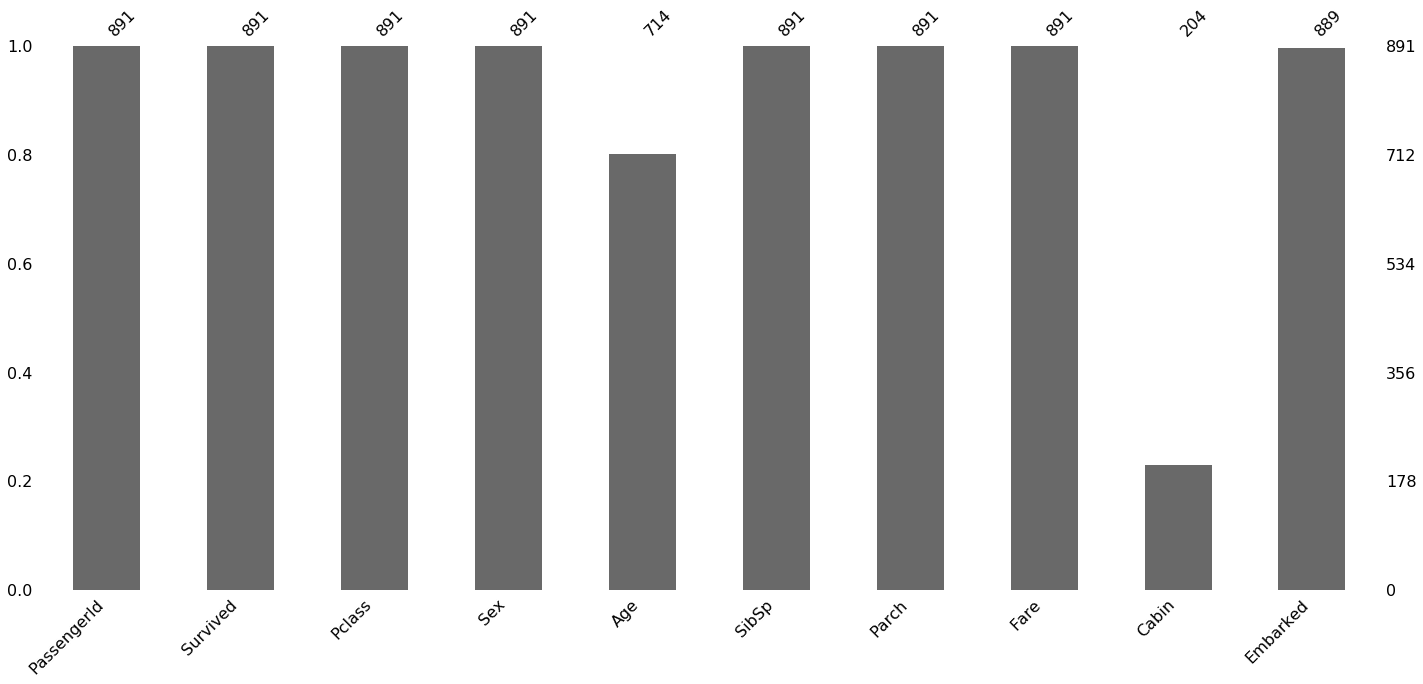

In [64]:
import missingno as msno

msno.bar(data)

# Display bar chart of missing values
display("/Users/usuariomac/Desktop/ML/missing.png")

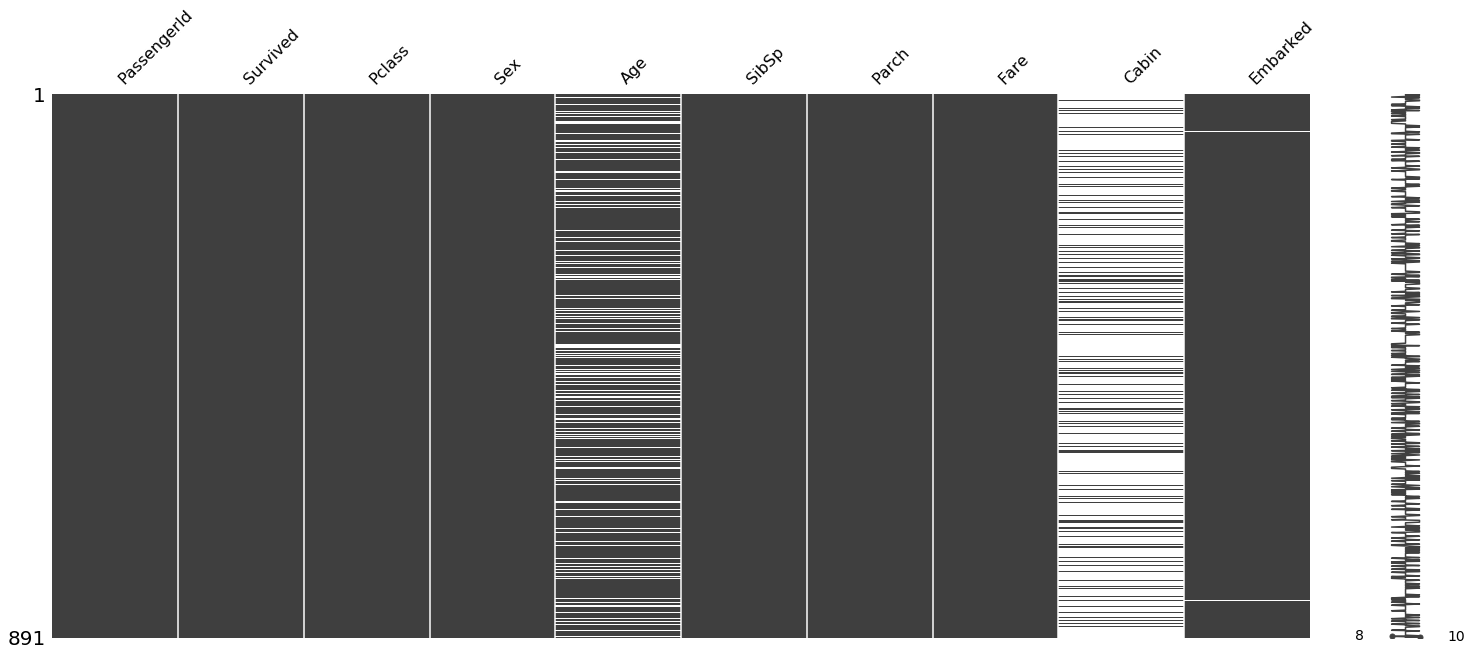

In [65]:
msno.matrix(data)

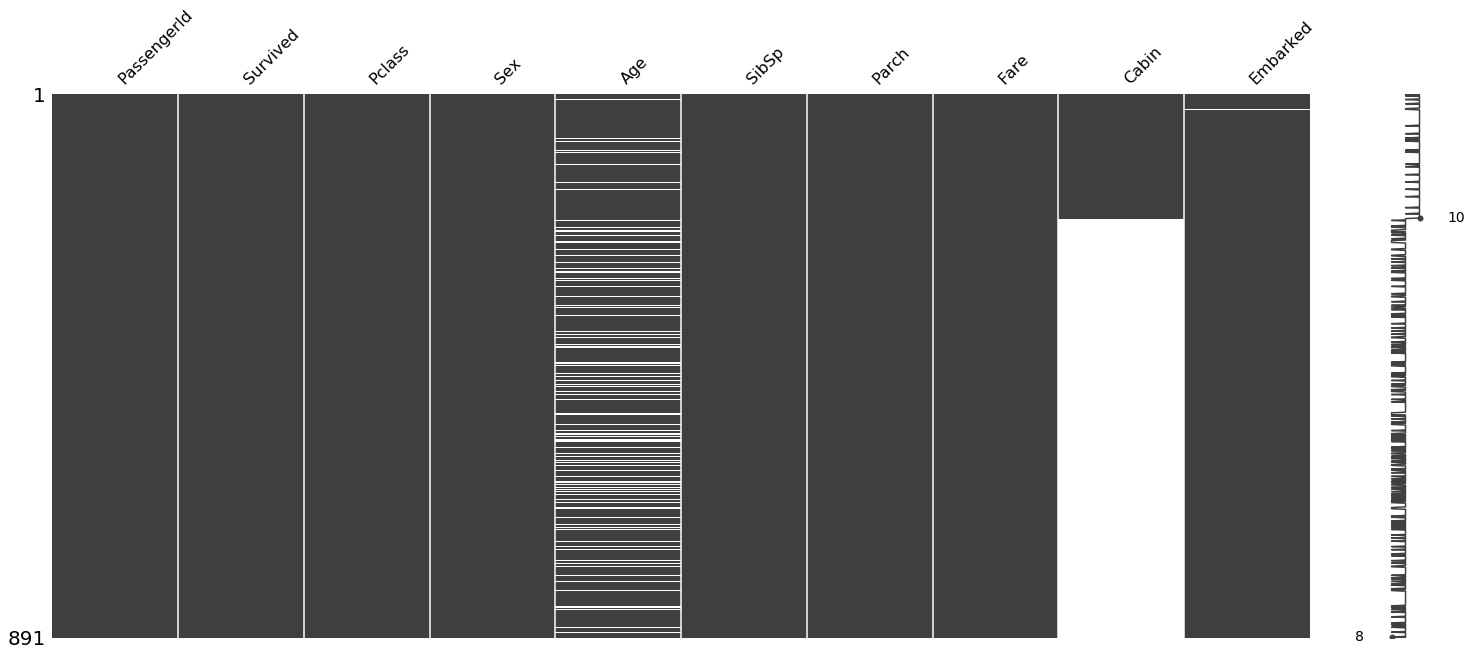

In [68]:
data_ordenada= data.sort_values("Cabin")
msno.matrix(data_ordenada) #Alguna relación entre cabin y Age, parece ser que si. 

Según la literatura, se deben evaluar las razones para la existencia de los valores missing. Pueden ocurrir tres situaciones: 

    1.Missing Completely at Random (MCAR).
    2.Missing at Random (MAR) 
    3.Missing Not at Random (MNAR)

Detecting missingness pattern by sorting the variablesMapping missingness to MCAR, MAR & MNAR. 

Ahora, el paso siguiente es realizar una matriz de correlaciones y mapa de dendogramas entre los valores missing para ver cual es la versión más apropiada del algoritmo. 

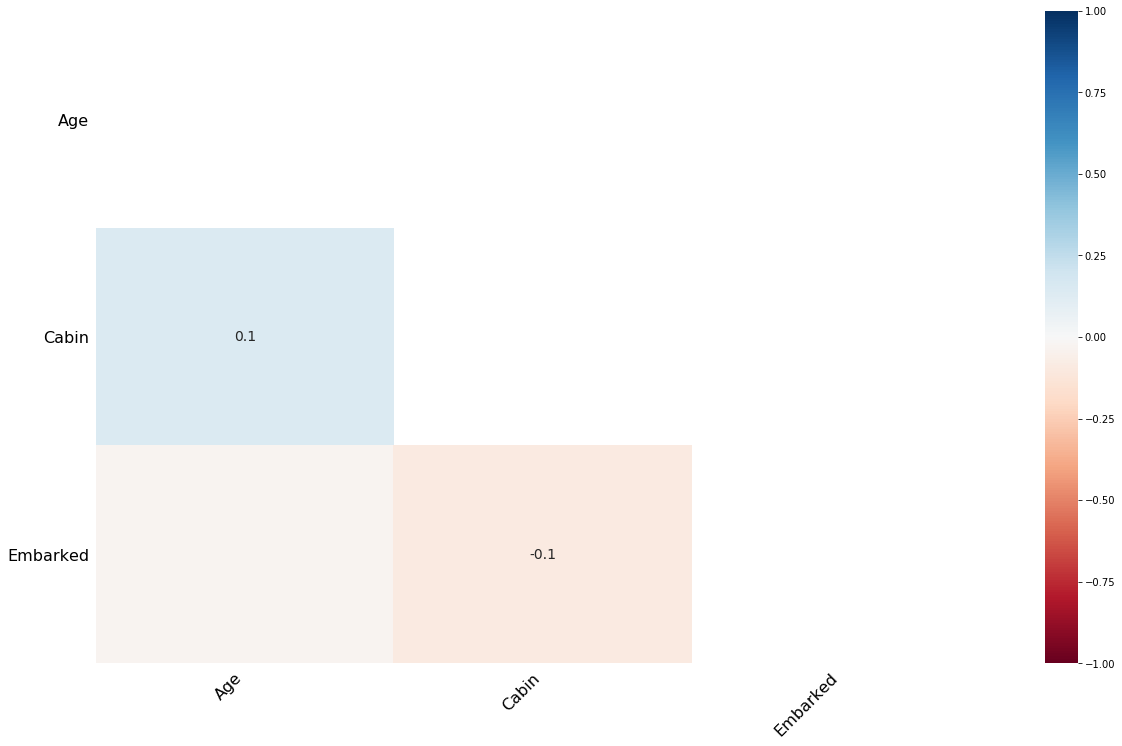

In [69]:
msno.heatmap(data_ordenada)

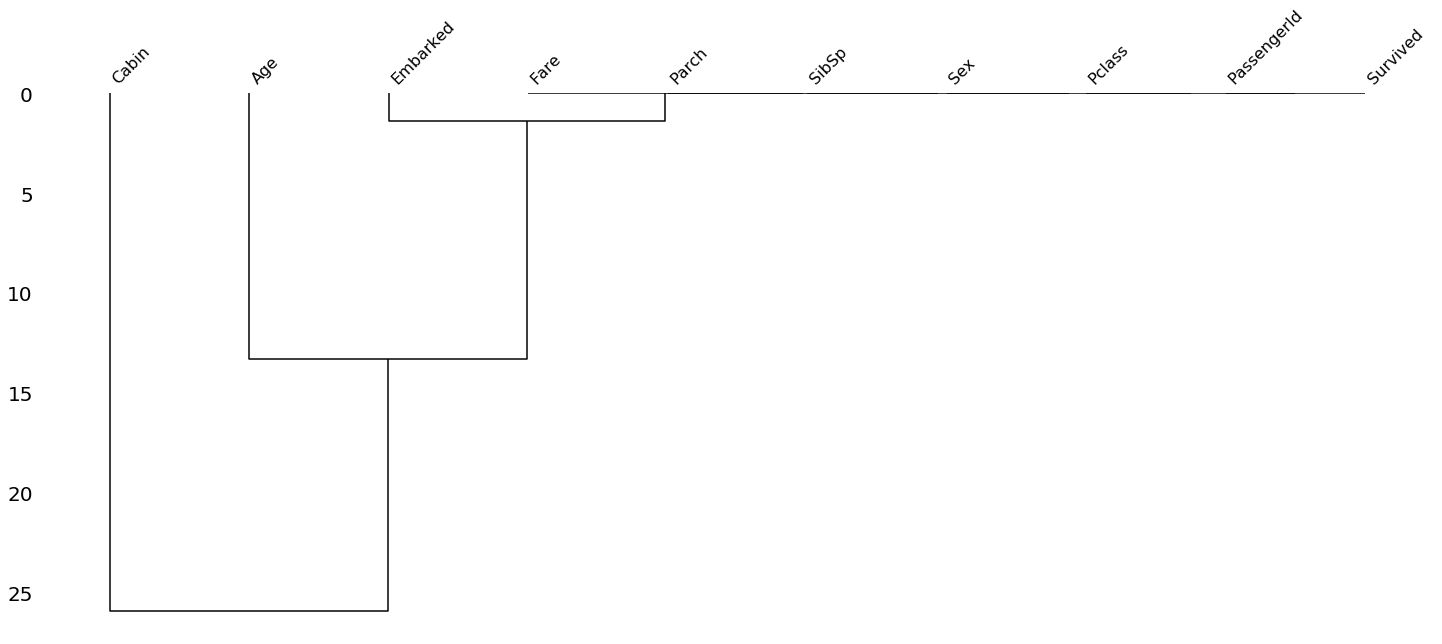

In [71]:
msno.dendrogram(data_ordenada) #Diagrama de arbol para datos faltantes, describe la correlación de las variables faltantes. 

In [72]:
from numpy.random import rand
def fill_dummy_values(df, scaling_factor):
    # Create copy of dataframe
    df_dummy = df.copy(deep=True)
    # Iterate over each column
    for col in df_dummy:
    # Get column, column missing values and range
        col = df_dummy[col]
        col_null = col.isnull()
        num_nulls = col_null.sum()
        col_range = col.max() - col.min()
        # Shift and scale dummy values
        dummy_values = (rand(num_nulls) - 2)
        dummy_values = dummy_values * scaling_factor * col_range + col.min()
        # Return dummy values
        col[col_null] = dummy_values
    return df_dummy

In [75]:
def fill_dummy_values(df):
  df_dummy = df.copy(deep=True)
  for col_name in df_dummy:
    col = df_dummy[col_name]
    col_null = col.isnull()    
    # Calculate number of missing values in column 
    num_nulls = col_null.sum()
  return df_dummy

In [82]:
# Fill dummy values in diabetes_dummy
data_dummy = fill_dummy_values(data_ordenada)
# Sum the nullity of Skin_Fold and BMI
nullity = data['Cabin'].isnull()+data['Age'].isnull()

In [126]:
# Create a scatter plot of Skin Fold and BMI 
#data_dummy.plot(x='Cabin', y='Age', kind='scatter', alpha=0.5, # Set color to nullity of BMI and Skin_Fold
#                 c=nullity, cmap='rainbow')
#plt.show()

In [133]:
from sklearn.impute import SimpleImputer

#1.
# Make a copy of data
data_mean = data.copy(deep=True)
data_mean=pd.get_dummies(data_mean)
# Create mean imputer object
mean_imputer = SimpleImputer(strategy='mean')
# Impute mean values in the DataFrame diabetes_mean
data_mean.iloc[:, :] = mean_imputer.fit_transform(data_mean)

data_mean
data_mean.describe(include='all').transpose()

#2. 
# Make a copy of data
data_mode = data.copy(deep=True)
# Create mode imputer object
mode_imputer = SimpleImputer(strategy="most_frequent")
# Impute using most frequent value in the DataFrame mode_imputer
data_mode.iloc[:, :] = mode_imputer.fit_transform(data_mode)

data_mode.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,891,NaN,NaN,NaN,28.567,13.1996,0.42,22,24,35,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329
Cabin,891,147,B96 B98,691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,891,3,S,646,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
#Fancy imputations: 

# Import KNN from fancyimpute
from fancyimpute import KNN

# Copy diabetes to diabetes_knn_imputed
data_knn_imputed = data.copy(deep=True)
data_knn_imputed=pd.get_dummies(data_knn_imputed)
# Initialize KNN
knn_imputer = KNN()

# Impute using fit_tranform on diabetes_knn_imputed
data_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(data_knn_imputed)
                                                       
data_knn_imputed.describe(include='all').transpose()                                            

Imputing row 1/891 with 0 missing, elapsed time: 2.078
Imputing row 101/891 with 0 missing, elapsed time: 2.084
Imputing row 201/891 with 0 missing, elapsed time: 2.088
Imputing row 301/891 with 1 missing, elapsed time: 2.090
Imputing row 401/891 with 0 missing, elapsed time: 2.092
Imputing row 501/891 with 0 missing, elapsed time: 2.095
Imputing row 601/891 with 0 missing, elapsed time: 2.097
Imputing row 701/891 with 0 missing, elapsed time: 2.099
Imputing row 801/891 with 0 missing, elapsed time: 2.101


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5,446.000000,668.5,891.0
Survived,891.0,0.383838,0.486592,0.00,0.0,0.000000,1.0,1.0
Pclass,891.0,2.308642,0.836071,1.00,2.0,3.000000,3.0,3.0
Age,891.0,29.690631,13.416884,0.42,21.0,28.454815,37.0,80.0
SibSp,891.0,0.523008,1.102743,0.00,0.0,0.000000,1.0,8.0
...,...,...,...,...,...,...,...,...
Cabin_G6,891.0,0.004489,0.066890,0.00,0.0,0.000000,0.0,1.0
Cabin_T,891.0,0.001122,0.033501,0.00,0.0,0.000000,0.0,1.0
Embarked_C,891.0,0.188552,0.391372,0.00,0.0,0.000000,0.0,1.0
Embarked_Q,891.0,0.086420,0.281141,0.00,0.0,0.000000,0.0,1.0


In [102]:
# Import IterativeImputer from fancyimpute
from fancyimpute import IterativeImputer

# Copy data to diabetes_mice_imputed
data_mice_imputed = data.copy(deep=True)
data_mice_imputed=pd.get_dummies(data_mice_imputed)
# Initialize IterativeImputer
mice_imputer = IterativeImputer()
# Impute using fit_tranform on data
data_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(data_mice_imputed)

data_mice_imputed.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.000000,223.5,446.0,668.5,891.0
Survived,891.0,0.383838,0.486592,0.000000,0.0,0.0,1.0,1.0
Pclass,891.0,2.308642,0.836071,1.000000,2.0,3.0,3.0,3.0
Age,891.0,29.382144,13.706682,-6.012759,21.0,29.0,36.0,80.0
SibSp,891.0,0.523008,1.102743,0.000000,0.0,0.0,1.0,8.0
...,...,...,...,...,...,...,...,...
Cabin_G6,891.0,0.004489,0.066890,0.000000,0.0,0.0,0.0,1.0
Cabin_T,891.0,0.001122,0.033501,0.000000,0.0,0.0,0.0,1.0
Embarked_C,891.0,0.188552,0.391372,0.000000,0.0,0.0,0.0,1.0
Embarked_Q,891.0,0.086420,0.281141,0.000000,0.0,0.0,0.0,1.0


Se debe evaluar el desempeño de las imputaciones, existen varias formas: 

    1. Realizando un grafico de las distribuciones de las imputaciones. 
    2. Realizando una regresión lineal. 

In [129]:
import statsmodels.api as sm
# Mean Imputation
data1 = data.copy(deep=True)
data1_cc = data1.dropna(how='any')
data1_cc=pd.get_dummies(data1_cc)
# Add constant to X and set X & y values to fit linear model
X = sm.add_constant(data1_cc.drop(['Age'], axis=1))
y = data_cc['Age']
lm = sm.OLS(y, X).fit()

,const,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,...,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
1,1.0,2,1,1,1,0,71.2833,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,4,1,1,1,0,53.1000,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1.0,7,0,1,0,0,51.8625,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10,1.0,11,1,3,1,1,16.7000,1,0,0,...,0,0,0,0,0,1,0,0,0,1
11,1.0,12,1,1,0,0,26.5500,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1.0,872,1,1,1,1,52.5542,1,0,0,...,0,0,0,0,0,0,0,0,0,1
872,1.0,873,0,1,0,0,5.0000,0,1,0,...,0,0,0,0,0,0,0,0,0,1
879,1.0,880,1,1,0,1,83.1583,1,0,0,...,0,0,0,0,0,0,0,1,0,0
887,1.0,888,1,1,0,0,30.0000,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [131]:
#X = sm.add_constant(data_mean.drop(['Age'], axis=1))
#y = data_cc['Age']
#lm_mean = sm.OLS(y, X).fit()
# KNN Imputation
X = sm.add_constant(data_knn_imputed.drop(['Age'], axis=1))
lm_KNN = sm.OLS(y, X).fit()
# MICE Imputation
X = sm.add_constant(data_mice_imputed.drop(['Age'], axis=1))
lm_MICE = sm.OLS(y, X).fit()

ValueError: The indices for endog and exog are not aligned

In [ ]:
data_cc

In [118]:
data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329
Cabin,204,147,C23 C25 C27,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,NaN,S
887,888,1,1,female,19.0,0,0,30.0000,B42,S
888,889,0,3,female,NaN,1,2,23.4500,NaN,S
889,890,1,1,male,26.0,0,0,30.0000,C148,C
